Enter submission file paths one by one. You can input glob patterns (e.g. submissions/*.csv).
Type 'done' or 'exit' or press Enter on an empty line to finish and show the comparison chart.

Comparison Summary:
  best_model_svm_predictions.csv: 94.74%

Comparison Summary:
  best_model_svm_predictions.csv: 94.74%


C:\Users\MSI KATANA\AppData\Local\Temp\ipykernel_11476\2559206170.py:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=acc_vals, y=labels, palette='viridis')


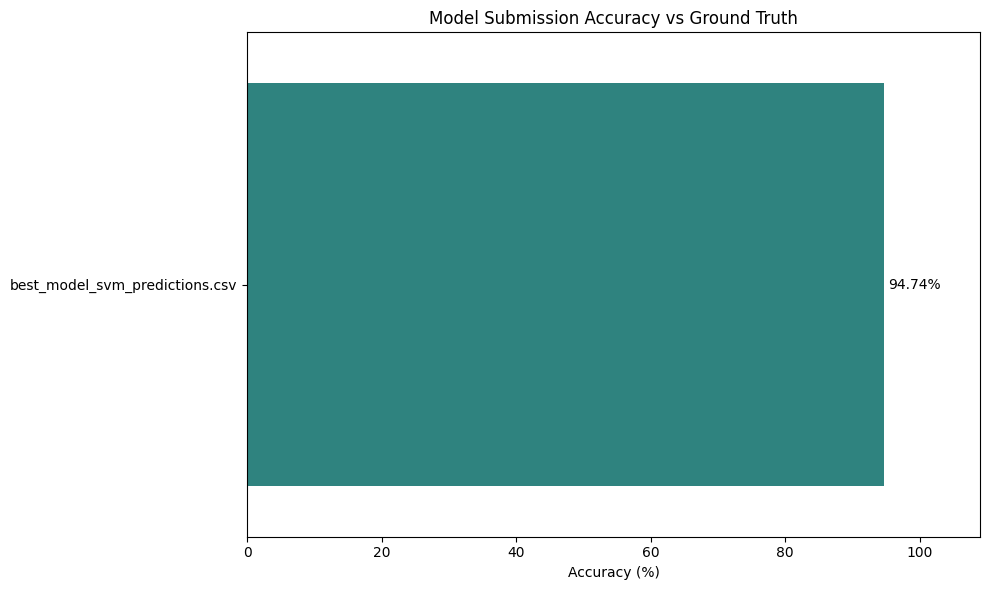

In [1]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_accuracy(model_submission_file, ground_truth_file):
    """
    Calculates the accuracy of a model's submission against a ground truth file.
    """
    try:
        model_df = pd.read_csv(model_submission_file)
        truth_df = pd.read_csv(ground_truth_file)

        if 'PassengerId' not in model_df.columns or 'Survived' not in model_df.columns:
            raise ValueError("Model submission file must contain 'PassengerId' and 'Survived' columns.")
        if 'PassengerId' not in truth_df.columns or 'Survived' not in truth_df.columns:
            raise ValueError("Ground truth file must contain 'PassengerId' and 'Survived' columns.")

        model_df = model_df.sort_values(by='PassengerId').reset_index(drop=True)
        truth_df = truth_df.sort_values(by='PassengerId').reset_index(drop=True)

        if not model_df['PassengerId'].equals(truth_df['PassengerId']):
            common_ids = set(model_df['PassengerId']).intersection(set(truth_df['PassengerId']))
            if not common_ids:
                print(f"No common PassengerIds between {model_submission_file} and {ground_truth_file}.")
                return None
            model_filtered = model_df[model_df['PassengerId'].isin(common_ids)].sort_values(by='PassengerId').reset_index(drop=True)
            truth_filtered = truth_df[truth_df['PassengerId'].isin(common_ids)].sort_values(by='PassengerId').reset_index(drop=True)
            y_pred = model_filtered['Survived']
            y_true = truth_filtered['Survived']
        else:
            y_pred = model_df['Survived']
            y_true = truth_df['Survived']

        correct_predictions = (y_pred == y_true).sum()
        total_predictions = len(y_pred)
        if total_predictions == 0:
            return None
        accuracy = correct_predictions / total_predictions
        return accuracy * 100

    except FileNotFoundError as e:
        print(f"Error: File not found - {e}")
        return None
    except ValueError as e:
        print(f"Error: {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred for {model_submission_file}: {e}")
        return None

# --- Interactive collection and comparison ---
if __name__ == '__main__':
    ground_truth = 'gender_submission.csv'
    if not os.path.exists(ground_truth):
        print(f"Ground truth file '{ground_truth}' not found in working directory ({os.getcwd()}).")
    submission_files = []
    print("Enter submission file paths one by one. You can input glob patterns (e.g. submissions/*.csv).")
    print("Type 'done' or 'exit' or press Enter on an empty line to finish and show the comparison chart.")

    while True:
        user_input = input('Submission file (or pattern), or done: ').strip()
        if user_input.lower() in ('done', 'exit', 'quit', ''):
            break
        # allow comma-separated on single line
        parts = [p.strip() for p in user_input.split(',') if p.strip()]
        for p in parts:
            # expand glob patterns
            if any(ch in p for ch in ['*', '?', '[']):
                matched = glob.glob(p)
                if matched:
                    submission_files.extend(matched)
                else:
                    print(f"Pattern '{p}' did not match any files.")
            else:
                submission_files.append(p)

    # deduplicate while preserving order
    seen = set(); unique_files = []
    for f in submission_files:
        if f not in seen:
            seen.add(f); unique_files.append(f)
    submission_files = unique_files

    if not submission_files:
        print("No submission files provided. Exiting.")
    else:
        results = []
        for path in submission_files:
            if not os.path.exists(path):
                print(f"Warning: '{path}' not found; skipping.")
                results.append((path, None))
                continue
            acc = calculate_accuracy(path, ground_truth)
            results.append((path, acc))

        # Prepare data for plotting (filter out None for plotting but show all in table)
        labels = [os.path.basename(r[0]) for r in results]
        acc_vals = [r[1] if r[1] is not None else 0.0 for r in results]
        mask = [r[1] is not None for r in results]

        # Print summary table
        print('\nComparison Summary:')
        for path, acc in results:
            if acc is None:
                print(f"  {path}: failed or missing")
            else:
                print(f"  {path}: {acc:.2f}%")

        # Plot bar chart: show NA as zero but annotate missing
        plt.figure(figsize=(10, 6))
        sns.barplot(x=acc_vals, y=labels, palette='viridis')
        plt.xlabel('Accuracy (%)')
        plt.title('Model Submission Accuracy vs Ground Truth')
        for i, (label, val, ok) in enumerate(zip(labels, acc_vals, mask)):
            if not ok:
                plt.text(val + 0.5, i, ' missing/failed', va='center', color='red')
            else:
                plt.text(val + 0.5, i, f'{val:.2f}%', va='center')
        plt.xlim(0, max(acc_vals) * 1.15 if acc_vals else 1)
        plt.tight_layout()
        plt.show()